In [1]:
import numpy as np
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=17)

# Hungry Crying Baby

In [2]:
def update_hunger(sttate, count):
    hunger = sttate['h']
    if count > 0:
        return hunger + 1/(np.power(2, count))
    else:
        return hunger

def update_food(sstate, probability, rgen):
    cries, food = sstate['c'], sstate['f']
    if cries and not food:
        return rgen.choice([0, 1], p=[1-probability, probability])
    else:
        return 0

def eat(sstate):
    if sstate['f']:
        return {'h': 0, 'f': 1, 'c': 0, 'e': 1}
    else:
        s = sstate.copy()
        s['e'] = 1
        return s

def check_for_eat(sstate):
    if sstate['h'] > 0:
        if sstate['f'] == 1:
            if sstate['e'] == 0:
                return True
    return False

def check_for_cry(sstate, hunger_threshold):
    return sstate['h'] > hunger_threshold
        
def cry(sstate):
    s = sstate.copy()
    s['c'], s['e'] = (1, 0)
    return s

In [3]:
rng = np.random.default_rng()
state = {'h': 0, 'f': 0, 'c': 0, 'e': 0}
NUM_TIMESTEPS = 50
times = np.arange(1, 1 + NUM_TIMESTEPS)
P_FOOD = .5
HUNGER_THRESHOLD = .9
states = [state]
cries, eats = [], []
last_eaten = 0
for t in times:
    new_state = states[-1].copy()
    
    # run food independent dynamics
    new_state['f'] = update_food(new_state, P_FOOD, rng)
    
    # reset eating action
    new_state['e'] = 0
    
    if check_for_eat(new_state):
#         print(t, 'eats')
        new_state = eat(new_state)
        eats.append(t)
        states.append(new_state)
        last_eaten = 0
        continue
        
    last_eaten += 1
    
    # hunger independent dynamics only happen if not eating
    new_state['h'] = update_hunger(new_state, last_eaten)
    
    if check_for_cry(new_state, HUNGER_THRESHOLD):
#         print(t, 'cries')
        new_state = cry(new_state)
        cries.append(t)
        states.append(new_state)
        continue
    states.append(new_state)
del states[0]
assert len(set(cries).intersection(set(eats))) == 0

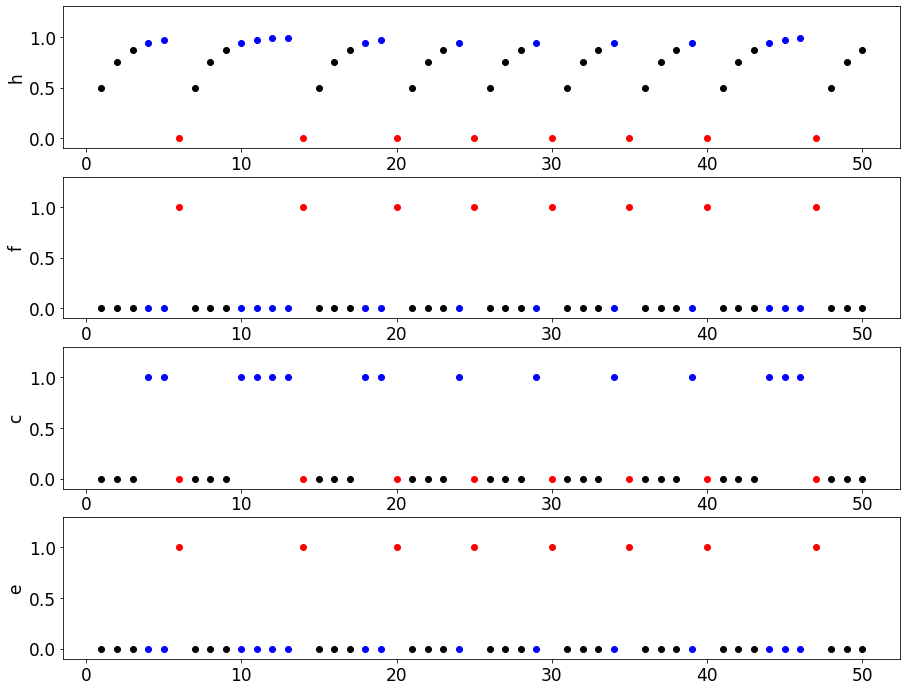

In [4]:
f, axes = plt.subplots(4, 1, figsize=(15, 12))
for ax, name in zip(axes, state.keys()):
    for ii, (t, s) in enumerate(zip(times, [d[name] for d in states])):
        if t in cries:
            c = 'blue'
        elif t in eats:
            c = 'red'
        else:
            c = 'k'
        ax.plot(t, s, 'o', color=c)
    ax.set_ylabel(name)
    ax.set_ylim([-0.1, 1.3])

# Honest answering machine

In [5]:
def update_food(s, p, r):
    """flips food state with probability p"""
    sc = s.copy()
    if r.choice([True, False], p=[p, 1-p]):
        sc['f'] = 1 - sc['f']
    return sc

def check_for_yes(s):
    return s['f'] and s['q'] == 'food'

def check_for_no(s):
    return not s['f'] and s['q'] == 'food'

def utter(s, word):
    sc = s.copy()
    sc['u'] = word
    return sc


PLOT_VALS_MAPPING = {
    'f': {0: 0, 1: 1},
    'q': {frozenset(set()): 0, 'food': 1},
    'u': {'no': 1, 'yes':2, frozenset(set()): 0}
}

state = {'f': 0, 'q': frozenset(set()), 'u': frozenset(set())}
NUM_TIMESTEPS = 50
P_ASK = .2  # probability that interlocutor asks about food presence on any timestep, independently
times = np.arange(1, 1 + NUM_TIMESTEPS)
P_FOOD = .2  # proability food state switches
states = [state]
yess, nos = [], []
for t in times:
    new_state = states[-1].copy()
    
    # run food independent dynamics
    new_state = update_food(new_state, P_FOOD, rng)
    
    # interlocutor independent dynamics
    new_state['q'] = frozenset(set())
    if rng.random() <= P_ASK:
        new_state['q'] = 'food'
    
    # reset utterance action
    new_state['u'] = frozenset(set())
    
    if check_for_yes(new_state):
        new_state = utter(new_state, 'yes')
        yess.append(t)
        states.append(new_state)
        continue
    
    if check_for_no(new_state):
        new_state = utter(new_state, 'no')
        nos.append(t)
        states.append(new_state)
        continue
    states.append(new_state)
del states[0]
assert len(set(yess).intersection(set(nos))) == 0

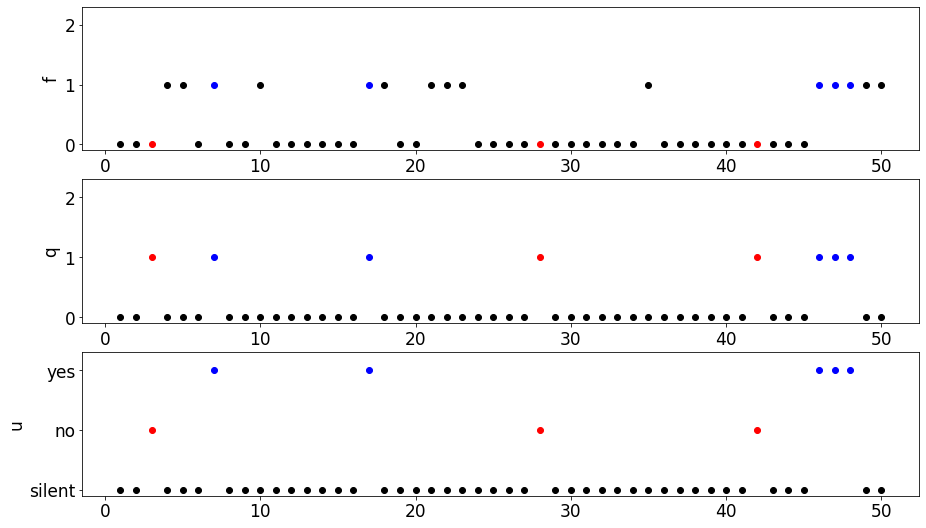

In [6]:
f, axes = plt.subplots(3, 1, figsize=(15, 9))
for ax, name in zip(axes, state.keys()):
    for ii, (t, s) in enumerate(zip(times, [d[name] for d in states])):
        if t in yess:
            c = 'blue'
        elif t in nos:
            c = 'red'
        else:
            c = 'k'
        try:
            ax.plot(t, PLOT_VALS_MAPPING[name][s], 'o', color=c)
        except KeyError:
            print(name, s)
            pprint(PLOT_VALS_MAPPING)
    ax.set_ylabel(name)
    ax.set_ylim([-0.1, 2.3])
    if name == 'u':
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['silent', 'no', 'yes'])